# Advanced Lane Finding

## Import libraries

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import cv2
import glob
import os

from moviepy.editor import VideoFileClip

In [26]:
#out_dir = 'output_images/'
out_dir = 'out_2_imgs/'

# Utility method to save images
def save_img(img, name):
    #rbg_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(out_dir+name, img)


## Load Camera Calibration Images

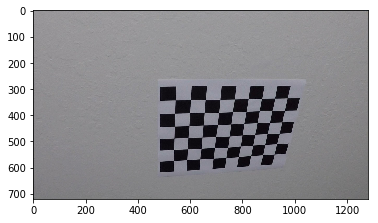

In [27]:
cal_images = glob.glob('camera_cal/calibration*.jpg')

# Print an example
example_img = mpimg.imread(cal_images[16])
plt.imshow(example_img)

In [28]:
# Object points - points in 3D world
obj_points = []

# Image points - points in 2D world on flat surface
img_points = []

# Prepare object points (9x6 chessboard)
# (x, y, z)
# (0, 0, 0), (1, 0, 0) ... (8, 5, 0)

# Create array of 9x6 points with 3 points x,y,z each
objp = np.zeros((9*6, 3), np.float32)

# Assign proper points values to objp
# Z coordinate will remain zero always
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)


camera_cal/calibration3.jpg
Total images with corners: 17
17
17


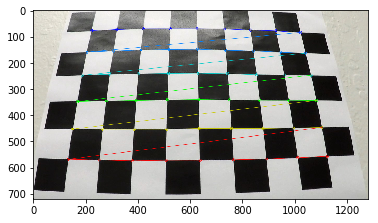

In [29]:
# Calculating Image points from image using openCV

count = 0
for img_path in cal_images:
    # Read each image
    img = mpimg.imread(img_path)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    # Are corners found?
    if ret == True:
        
        # Add image and object points for each image found having corners
        obj_points.append(objp)
        img_points.append(corners)
        
        # Draw image, corners for one image
        if count == 2:
            corner_img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
            print(img_path)
            plt.figure()
            plt.imshow(img)
            cv2.imwrite(out_dir+'draw_corners.jpg', img)
        
        # Increase count only for images with corners found
        count = count + 1

print('Total images with corners: {}'.format(count))
print(len(obj_points))
print(len(img_points))

## Calibrate Camera using Image and Object points

In [30]:
# Calibrate camera
# mtx = Camera matrix
# dist = Distortion Coefficients

ret, mtx, dist, rvects, tvects = cv2.calibrateCamera(obj_points, img_points, example_img.shape[1::-1], None, None)

## Undistort an image

True

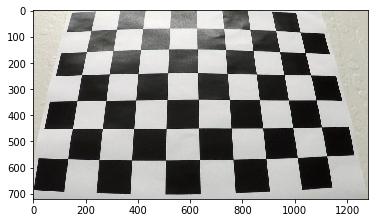

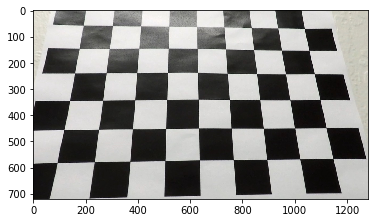

In [31]:
# Undistort image fucntion
def undistort_img(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

# Undistort example image
example_img = mpimg.imread(cal_images[4])
plt.figure()
plt.imshow(example_img)
cv2.imwrite(out_dir+'distorted_img.jpg', example_img)

undist_img = undistort_img(example_img, mtx, dist)
plt.figure()
plt.imshow(undist_img)
cv2.imwrite(out_dir+'un_distorted_img.jpg', undist_img)

## Undistort Test Images

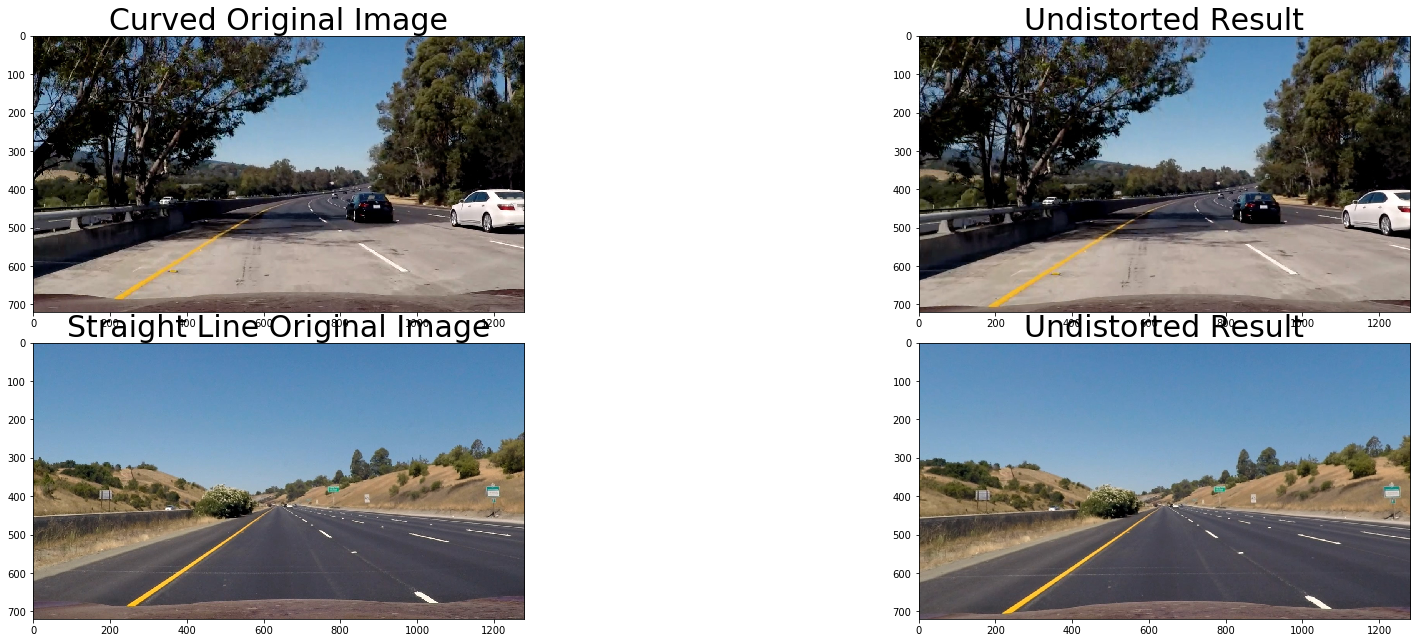

In [9]:
# Read all test images
test_img_dir = 'test_images/'
images = os.listdir(test_img_dir)
test_images = []

# Append image directory to all files
for img in images:
    test_images.append(test_img_dir + img)

curved_img = mpimg.imread(test_images[1])
straight_line_img = mpimg.imread(test_images[7])

f, axes = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()

axes[0,0].imshow(curved_img)
axes[0,0].set_title('Curved Original Image', fontsize=30)

undistort_curved_result = undistort_img(curved_img, mtx, dist)

axes[0,1].imshow(undistort_curved_result)
axes[0,1].set_title('Undistorted Result', fontsize=30)

axes[1,0].imshow(straight_line_img)
axes[1,0].set_title('Straight Line Original Image', fontsize=30)

undistort_straight_result = undistort_img(straight_line_img, mtx, dist)

axes[1,1].imshow(undistort_straight_result)
axes[1,1].set_title('Undistorted Result', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [32]:
# Change this flag to true if want to save images
DBG = False

## Compute Color and Gradient Threshold

In [98]:

# Calculate Sobel threshold
def sobel_threshold(img, sobel_thresh=(0, 255), orientation='x', kernel_size=3):
    # Convert to Grayscale color space
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate gradient in 'orientation' direction
    if orientation == 'x':
        sobel_val = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    else:
        sobel_val = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
        
    # Calculate absolute value
    abs_sobel = np.absolute(sobel_val)
    
    #Scale the soebl values to 8-bit image
    scaled_sobel = np.uint8( (255*abs_sobel) / np.max(abs_sobel) )
    
    # Create a binary image based on sobel
    sobel_binary = np.zeros_like(scaled_sobel)
    
    sobel_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel < sobel_thresh[1])] = 1
    
    return sobel_binary





def select_yellow(img):
    # Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    lower = np.array([20,60,60])
    upper = np.array([38,174,250])
    
    mask = cv2.inRange(hsv, lower, upper)

    return mask


def select_white(image):
    
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image, lower, upper)

    return mask



def color_comb_thresh(image):
    
    yellow = select_yellow(image)
    white = select_white(image)
    
    combined_binary = np.zeros_like(yellow)
    
    if DBG == True:
        out_img_yellow = np.zeros_like(image[:,:,0])
        out_img_yellow[(yellow >= 1)] = 255
        save_img(out_img_yellow, '4_1_out_img_yellow.jpg')
        
        out_img_white = np.zeros_like(image[:,:,0])
        out_img_white[(white >= 1)] = 255
        save_img(out_img_white, '4_1_out_img_white.jpg')
        
        
    combined_binary[(yellow >= 1) | (white >= 1)] = 1
    
    return combined_binary



#Calculate color threshold
def color_threshold(img, s_color_thresh=(0, 255), v_color_thresh=(0, 255)):
    # Convert to HLS color space
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls_img[:,:,2]
    l_channel = hls_img[:,:,1]
    
    # Convert to HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hls_img[:,:,2]

    
    # Get the R-Channel
    r_channel = img[:,:,0]
    r_color_binary = np.zeros_like(r_channel)
    #r_color_binary[(r_channel >= 100) & (r_channel <= 120)] = 1
    r_color_binary[(r_channel >= 190) & (r_channel <= 255)] = 1
    
    
    
    # Get the G-Channel
    g_channel = img[:,:,1]
    g_color_binary = np.zeros_like(g_channel)
    #g_color_binary[(g_channel >= 110) & (g_channel <= 120)] = 1
    g_color_binary[(g_channel >= 190) & (g_channel <= 255)] = 1
    
    
    yellow_color_binary = np.zeros_like(r_channel)
    yellow_color_binary[(r_color_binary == 1) | (g_color_binary == 1)] = 1
    
    white_color_binary = np.zeros_like(r_channel)
    white_color_binary[(r_channel >= 200) & (r_channel <= 255) | ((g_channel >= 200) & (g_channel <= 255))] = 1
    
    
    # Create an array like S-channel
    s_color_binary = np.zeros_like(s_channel)
    
    # Set pixel points to 1 where S-channel is between thresholds
    s_color_binary[(s_channel >= s_color_thresh[0]) & (s_channel <= s_color_thresh[1])] = 1
    

    
    # Create an array like L-channel
    l_color_binary = np.zeros_like(l_channel)
    
    # Set pixel points to 1 where L-channel is between thresholds
    l_color_binary[(l_channel >= 190) & (l_channel <= 245)] = 1
    
    
    combined_color_binary = np.zeros_like(s_channel)
    #combined_color_binary[(s_color_binary == 1)] = 1
    
    combined_color_binary[((s_color_binary == 1)| (l_color_binary == 1)) | ((yellow_color_binary == 1) | (white_color_binary == 1))] = 1
    
    
    if DBG == True:
        out_img_R_color = np.zeros_like(img[:,:,0])
        out_img_R_color[(r_color_binary == 1)] = 255
        save_img(out_img_R_color, '1_1_out_img_R_color.jpg')
    
        out_img_G_color = np.zeros_like(img[:,:,0])
        out_img_G_color[(g_color_binary == 1)] = 255
        save_img(out_img_G_color, '1_2_out_img_G_color.jpg')
        
        out_img_Yello_color = np.zeros_like(img[:,:,0])
        out_img_Yello_color[(yellow_color_binary == 1)] = 255
        save_img(out_img_Yello_color, '1_4_out_img_Yello_color.jpg')
        
        out_img_White_color = np.zeros_like(img[:,:,0])
        out_img_White_color[(white_color_binary == 1)] = 255
        save_img(out_img_White_color, '1_5_out_img_White_color.jpg')
    
    
        out_img_s_color = np.zeros_like(img[:,:,0])
        out_img_s_color[(s_color_binary == 1)] = 255
        save_img(out_img_s_color, '1_3_out_img_s_color.jpg')

        #out_img_v_color = np.zeros_like(img[:,:,0])
        #out_img_v_color[(v_color_binary == 1)] = 255
        #save_img(out_img_v_color, '2_out_img_v_color.jpg')

        out_img_L_color = np.zeros_like(img[:,:,0])
        out_img_L_color[(l_color_binary == 1)] = 255
        save_img(out_img_L_color, '2_1_out_img_L_color.jpg')
        
        out_img_combined_color = np.zeros_like(img[:,:,0])
        out_img_combined_color[(combined_color_binary == 1)] = 255
        save_img(out_img_combined_color, '3_out_img_combined_color.jpg')
    
    
    return combined_color_binary



def combined_binary(img):
    
    out_img = np.zeros_like(img[:,:,0])
    
    sobel_x = sobel_threshold(img, sobel_thresh=(50, 255), orientation='x')
    sobel_y = sobel_threshold(img, sobel_thresh=(24, 255), orientation='y')
    
    #sobel_x = sobel_threshold(img, sobel_thresh=(12, 255), orientation='x')
    #sobel_y = sobel_threshold(img, sobel_thresh=(20, 255), orientation='y')
    
    #color_thresh = color_threshold(img, s_color_thresh=(95, 150), v_color_thresh=(50, 150))
    #color_thresh = color_threshold(img, s_color_thresh=(115, 138), v_color_thresh=(30, 60))
    
    color_thresh = color_comb_thresh(img)
    
    
    if DBG == True:
        out_img_x = np.zeros_like(img[:,:,0])
        out_img_x[(sobel_x == 1)] = 255
        save_img(out_img_x, '4_1_sobel_x.jpg')

        out_img_y = np.zeros_like(img[:,:,0])
        out_img_y[(sobel_y == 1)] = 255
        save_img(out_img_y, '4_2_sobel_y.jpg')


        out_img_xy = np.zeros_like(img[:,:,0])
        out_img_xy[(sobel_x == 1) & (sobel_y == 1)] = 255
        save_img(out_img_xy, '4_3_sobel_xy.jpg')

        out_img_color = np.zeros_like(img[:,:,0])
        out_img_color[(color_thresh == 1)] = 255
        save_img(out_img_color, '5_color_thresh.jpg')
    
    #out_img[( (sobel_x == 1) & (sobel_y == 1) | (color_thresh == 1) )] = 255
    out_img[(sobel_x == 1) | (color_thresh == 1)] = 255
    
    return out_img

## Perspective transform

In [93]:
# Store the src points for straight line image

def warp_image(img):
    
    # (size) = (    x       ,     y       )
    img_size = (img.shape[1], img.shape[0])
    
    # Calculate source and destination points        
    lower_left_pt = [200., 720.]
    upper_left_pt = [570., 470.]
    upper_right_pt = [720., 470.]
    lower_right_pt = [1130., 720.]
    
    src = np.float32([lower_left_pt, upper_left_pt, upper_right_pt, lower_right_pt])
    
    dst = np.float32([
        [350., 720.],
        [350., 0],
        [980, 0],
        [980, 720.]
    ])
    
    
    # Get the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #Warp the image
    warped_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped_img, Minv

## Find lane lines using convolution

In [94]:
class LaneLineFinder():
    def __init__(self, win_width, win_height, margin, no_of_fits, prev_img_centroids):
        self.window_width = win_width
        
        self.window_height = win_height
        
        self.window_margin = margin
        
        self.recent_window_centroids = []
        
        self.no_of_fits = no_of_fits
        
        self.prev_img_window_centroids = prev_img_centroids
    
    
    # Find the window centroids in image
    def find_window_centroids(self, warped_img):
        
        # Store the (left,right) window centroid positions per level
        window_centroids = []
        
        # Create our window template that we will use for convolutions
        window = np.ones(self.window_width)

        # Now find the starting position of left and right lane markers by first summing
        # the vertical slice of image (Use 10% of bottom of image)
        
        #y_upper_limit = int(3*warped_img.shape[0]/4)
        y_upper_limit = int(0.5*warped_img.shape[0])
        
        # Find left and right cut off points (Use 45% of left and 45% of right)
        # Use this for first window
        x_left_min = int(warped_img.shape[1]*0.1)
        x_left_max = int(warped_img.shape[1]*0.45)
        
        x_right_min = int(warped_img.shape[1]*0.6)
        x_right_max = int(warped_img.shape[1]*0.9)
        
        # For next consecutive windows use mid point
        x_mid = int(warped_img.shape[1]/2)

        if DBG == True:
            print("Limits")
            print("X Left: ({}, {})".format(x_left_min, x_left_max))
            print("X Right: ({}, {})".format(x_right_min, x_right_max))
            print("X Mid: {}, y upper: {}".format(x_mid, y_upper_limit))
        
        
        #left_slice = np.sum(warped_img[y_upper_limit:, x_left_min:x_left_max], axis=0)
        left_slice = np.sum(warped_img[y_upper_limit:, x_left_min:x_mid], axis=0)
        left_center = (np.argmax(np.convolve(window, left_slice)) - (self.window_width/2) + x_left_min)
        
        right_slice = (np.sum(warped_img[y_upper_limit:, x_right_min:x_right_max], axis=0))
        #right_slice = (np.sum(warped_img[y_upper_limit:, x_mid:x_right_max], axis=0))
        right_center = (np.argmax(np.convolve(window, right_slice)) - (self.window_width/2) + x_right_min)
        #right_center = (np.argmax(np.convolve(window, right_slice)) - (self.window_width/2) + x_mid)
        
        #Append the first bottom window centroids
        window_centroids.append((left_center, right_center))
        
        if DBG == True:
            print("Center: {}, {}".format(left_center, right_center))

        #Total levels in image
        levels = int(warped_img.shape[0]/self.window_height)
        
        #Loop over all windows to find window centroids:
        for level in range(1, levels):
            
            if DBG == True:
                print()
                print("Level: {}".format(level))

            #Get the window slice for level
            y_upper_limit = (warped_img.shape[0] - ((level + 1) * self.window_height))
            y_lower_limit = (warped_img.shape[0] - (level * self.window_height))
            
            image_layer = np.sum(warped_img[y_upper_limit:y_lower_limit,:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            
            
            offset = (self.window_width/2)
            
            #Use (left, right) found earlier to look up around that area for next best window centroid
            left_min = int(max(left_center + offset - self.window_margin, 0))
            left_max = int(min(left_center + offset + self.window_margin, warped_img.shape[1]))
            
            left_argmax = np.argmax(conv_signal[left_min:left_max])
            
            if left_argmax != 0:
                if DBG == True:
                    print("Left argmax is : {}".format(left_argmax))
                left_center = (left_argmax + left_min - offset)
            else:
                if DBG == True:
                    print('No values in left center')
            
            right_min = int(max(right_center + offset - self.window_margin, 0))
            right_max = int(min(right_center + offset + self.window_margin, warped_img.shape[1]))
            
            right_argmax = np.argmax(conv_signal[right_min:right_max])
                      
            if right_argmax != 0:
                if DBG == True:
                    print("right argmax conv is: {}".format(right_argmax))
                right_center = (right_argmax + right_min - offset)
            else:
                if DBG == True:
                    print('No values in right center')
            
            if DBG == True:
                print("y_upper_limit: {} , y_lower_limit: {}".format(y_upper_limit, y_lower_limit))
                print("left_min: {}, left_max: {}, left_center: {}".format(left_min, left_max, left_center))
                print("right_min: {}, right_max: {}, right_center: {}".format(right_min, right_max, right_center))
            # Add new window centroids
            window_centroids.append((left_center, right_center))
        
        # Append window centroids found for this frame to global window centroids
        self.recent_window_centroids.append(window_centroids)
        
        #Return the average of last 'n' frame's window centres
        return np.average(self.recent_window_centroids[-self.no_of_fits:], axis=0)
        #return self.recent_window_centroids
    

In [95]:
def window_mask(img, win_width, win_height, win_center, win_level):
    out_img = np.zeros_like(img)
    
    y_upper_pt = int(img.shape[0] - ((win_level + 1) * win_height))
    y_lower_pt = int(img.shape[0] - (win_level * win_height))
    
    x_left_pt = max(0, int(win_center - (win_width / 2) ))
    x_right_pt = min(int(win_center + (win_width / 2) ), img.shape[1])
    
    out_img[y_upper_pt:y_lower_pt, x_left_pt:x_right_pt] = 1
    
    #output_img_name = './output_images/new/img_frame_out_'+str(win_level)+'.jpg'
    #cv2.imwrite(output_img_name, out_img)
    return out_img

## Pipeline for finding lane lines in Images or Videos

In [100]:
class VideoProc():
    def __init__(self):
        self.count = 0
        
        self.prev_img_window_centroids = []

    def process_image(self, img):

        #Undistort the image
        img_undistort = undistort_img(img, mtx, dist)
        #save_img(img_undistort, 'normal/frame_'+str(self.count)+'.jpg')

        img_warped, Minv = warp_image(img_undistort)
        if DBG == True:
            save_img(img_warped, '6_orig_img_warped.jpg')
        
        # Apply gradient threshold
        img_threshold = combined_binary(img_undistort)
        if DBG == True:
            save_img(img_threshold, '7_threshold.jpg')
        
        
        #Apply perspective transform
        img_warped, Minv = warp_image(img_threshold)
        if DBG == True:
            save_img(img_warped, '8_warped.jpg')

        
        # Window Attributes
        window_width = 25
        window_height = 80
        window_margin = 75

        #Curvature attributes
        y_m_per_pixel = 30/720
        x_m_per_pixel = 3.7/700
        offset = 0.0
        curvature = 0.0

        #Instantiate lane line finder class
        lane_line_finder = LaneLineFinder(win_width=window_width, win_height=window_height, margin=window_margin, no_of_fits=9, prev_img_centroids=self.prev_img_window_centroids)
        window_centroids = lane_line_finder.find_window_centroids(img_warped)

        self.prev_img_window_centroids = window_centroids
    
    
        #If window centers found, draw lane line markers
        if len(window_centroids) > 0:

            #(left, right) points used to draw window centers
            left_pts = np.zeros_like(img_warped)
            right_pts = np.zeros_like(img_warped)

            leftx = []
            rightx = []

            #Go through each window level and draw the windows
            for level in range(0, len(window_centroids)):
                leftx.append(window_centroids[level][0])
                rightx.append( window_centroids[level][1])

                left_mask = window_mask(img_warped, window_width, window_height, window_centroids[level][0], level)
                right_mask = window_mask(img_warped, window_width, window_height, window_centroids[level][1], level)

                # Add graphic points from window mask here to total pixels found
                left_pts[(left_pts == 255) | (left_mask == 1)] = 255
                right_pts[(right_pts == 255) | (right_mask == 1)] = 255

            # Draw the results
            # add both left and right window pixels together
            template = np.array(left_pts + right_pts, np.uint8)
            
            #Create zero-color channel
            zero_channel = np.zeros_like(template)

            #Color the window as green
            template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8)
            #save_img(template, 'template.jpg')
            
            #Make the original road pixels as 3 color channels
            orig_warped_img = np.dstack((img_warped, img_warped, img_warped))*255

            #Create the final image with template window drawn over the actual image
            img_warped_windowed = cv2.addWeighted(orig_warped_img, 1, template, 0.5, 0.0)
            if DBG == True:
                save_img(img_warped_windowed, '9_img_warped_windowed.jpg')
                plt.imshow(img_warped_windowed, cmap='gray')

            yvals = range(0, img_warped.shape[0])

            res_yvals = np.arange(img_warped.shape[0] - (window_height/2), 0, -window_height)

            left_fit = np.polyfit(res_yvals, leftx, 2)
            left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
            left_fitx = np.array(left_fitx, np.int32)


            right_fit = np.polyfit(res_yvals, rightx, 2)
            right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
            right_fitx = np.array(right_fitx, np.int32)


            left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2), axis=0), np.concatenate((yvals,yvals[::-1]), axis=0))), np.int32)
            right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2), axis=0), np.concatenate((yvals,yvals[::-1]), axis=0))), np.int32)

            lane_fill_area = np.array(list(zip(np.concatenate((left_fitx+window_width/2, right_fitx[::-1]-window_width/2), axis=0), np.concatenate((yvals,yvals[::-1]), axis=0))), np.int32)


            road = np.zeros_like(img_undistort)

            cv2.fillPoly(road, [left_lane], color=[255,0,0])
            cv2.fillPoly(road, [right_lane], color=[0,0,255])
            
            if DBG == True:
                save_img(road, '9_1_warped_windowed_lane_line.jpg')
                
            cv2.fillPoly(road, [lane_fill_area], color=[0,255,0])


            # Measure the curvature of car and offset
            # Fit new polynomials in real world space
            left_fit_real = np.polyfit((np.array(res_yvals, np.float32)*y_m_per_pixel), (np.array(leftx, np.float32) * x_m_per_pixel), 2)
            #right_fit_real = np.polyfit((res_yvals  *y_m_per_pixel), (rightx * x_m_per_pixel), 2)

            curvature = ( ( 1 + (2*left_fit_real[0]*yvals[-1]*y_m_per_pixel + left_fit_real[1])**2 )**1.5 ) / np.absolute(2*left_fit_real[0])
            #right_curverad = ( ( 1 + (2*right_fit_real[0]*yvals + right_fit_real[1])**2 )**1.5 ) / np.absolute(2*right_fit_real[0])


            # Measure the offset of the car from center
            center_x = ((left_fitx[-1] + right_fitx[-1]) / 2)
            warped_img_center = (img_warped.shape[1] / 2)
            offset = ((center_x - warped_img_center) * x_m_per_pixel)


            img_warped_windowed = road
            if DBG == True:
                save_img(img_warped_windowed, '10_warped_windowed.jpg')

        else:
            img_warped_windowed = np.array(cv2.merge((img_warped, img_warped, img_warped)), np.uint8)


        # Warp the thresholded image back to original image with lane lines drawn
        road_warped = cv2.warpPerspective(img_warped_windowed, Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

        # Add the original undistorted image onto inverse warped image
        lane_on_orig_img = cv2.addWeighted(img_undistort, 1.0, road_warped, 0.7, 0.0)


        offset_pos = 'right'
        if offset >= 0:
            offset_pos = 'left'

        offset = np.absolute(offset)

        # Write the curvature and offset onto image
        cv2.putText(lane_on_orig_img, 'Radius of curvature: '+str(round(curvature,3))+'(m)', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        cv2.putText(lane_on_orig_img, 'Offset of car: '+str(round(offset,3))+'(m) from '+offset_pos+' of center', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)


        out_img = lane_on_orig_img

        #save_img(out_img, 'lane/frame_'+str(self.count)+'.jpg')
        self.count = self.count+1
        # Finally return the processed image with lane lines drawn
        return out_img
    

## Test Pipeline on Images

In [107]:
# Test Pipeline on single image
DBG = False#True
processor = VideoProc()
count = 0
#1046, 739, 989, 552, 943, 985-990, 998, 1004, 1036-037, 1044-1045

#Read image
img = mpimg.imread("out_2_imgs/normal/frame_1045.jpg")
save_img(img, 'orig_img.jpg')

final_img = processor.process_image(img)

output_img_name = './out_2_imgs/11_img_frame_'+str(count)+'.jpg'
cv2.imwrite(output_img_name, final_img)

True

## Test Pipeline on Video

In [108]:
project_video_processor = VideoProc()

output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")

white_clip = clip.fl_image(project_video_processor.process_image)
%time white_clip.write_videofile(output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:00<02:30,  8.35it/s]



  0%|          | 2/1261 [00:00<02:28,  8.47it/s]



  0%|          | 3/1261 [00:00<02:25,  8.63it/s]



  0%|          | 4/1261 [00:00<02:25,  8.61it/s]



  0%|          | 5/1261 [00:00<02:21,  8.85it/s]



  0%|          | 6/1261 [00:00<02:18,  9.06it/s]



  1%|          | 7/1261 [00:00<02:16,  9.17it/s]



  1%|          | 8/1261 [00:00<02:16,  9.21it/s]



  1%|          | 9/1261 [00:00<02:17,  9.10it/s]



  1%|          | 10/1261 [00:01<02:19,  8.99it/s]



  1%|          | 11/1261 [00:01<02:22,  8.76it/s]



  1%|          | 12/1261 [00:01<02:20,  8.89it/s]



  1%|          | 13/1261 [00:01<02:30,  8.31it/s]



  1%|          | 14/1261 [00:01<02:35,  8.01it/s]



  1%|          | 15/1261 [00:01<02:40,  7.78it/s]



  1%|▏         | 16/1261 [00:01<02:35,  8.01it/s]



  1%|▏         | 17/1261 [00:02<02:40,  7.74it/s]



  1%|▏         | 18/1261 [00:02<02:41,  7.68it/s]



  2%|▏ 

 10%|▉         | 125/1261 [00:15<02:44,  6.90it/s]



 10%|▉         | 126/1261 [00:15<02:34,  7.35it/s]



 10%|█         | 127/1261 [00:15<02:27,  7.70it/s]



 10%|█         | 128/1261 [00:15<02:25,  7.79it/s]



 10%|█         | 129/1261 [00:15<02:20,  8.05it/s]



 10%|█         | 130/1261 [00:15<02:17,  8.24it/s]



 10%|█         | 131/1261 [00:16<02:13,  8.49it/s]



 10%|█         | 132/1261 [00:16<02:14,  8.41it/s]



 11%|█         | 133/1261 [00:16<02:10,  8.61it/s]



 11%|█         | 134/1261 [00:16<02:10,  8.65it/s]



 11%|█         | 135/1261 [00:16<02:12,  8.52it/s]



 11%|█         | 136/1261 [00:16<02:12,  8.50it/s]



 11%|█         | 137/1261 [00:16<02:09,  8.65it/s]



 11%|█         | 138/1261 [00:16<02:08,  8.73it/s]



 11%|█         | 139/1261 [00:16<02:06,  8.88it/s]



 11%|█         | 140/1261 [00:17<02:09,  8.68it/s]



 11%|█         | 141/1261 [00:17<02:08,  8.71it/s]



 11%|█▏        | 142/1261 [00:17<02:06,  8.85it/s]



 11%|█▏        | 143/1261 [0

 20%|█▉        | 249/1261 [00:30<02:02,  8.27it/s]



 20%|█▉        | 250/1261 [00:30<01:58,  8.56it/s]



 20%|█▉        | 251/1261 [00:31<01:53,  8.88it/s]



 20%|█▉        | 252/1261 [00:31<02:08,  7.84it/s]



 20%|██        | 253/1261 [00:31<02:06,  7.94it/s]



 20%|██        | 254/1261 [00:31<02:04,  8.11it/s]



 20%|██        | 255/1261 [00:31<02:00,  8.35it/s]



 20%|██        | 256/1261 [00:31<01:57,  8.53it/s]



 20%|██        | 257/1261 [00:31<01:55,  8.73it/s]



 20%|██        | 258/1261 [00:31<01:52,  8.92it/s]



 21%|██        | 260/1261 [00:32<01:49,  9.11it/s]



 21%|██        | 261/1261 [00:32<01:49,  9.17it/s]



 21%|██        | 262/1261 [00:32<01:50,  9.04it/s]



 21%|██        | 263/1261 [00:32<01:50,  9.02it/s]



 21%|██        | 264/1261 [00:32<01:57,  8.51it/s]



 21%|██        | 265/1261 [00:32<01:54,  8.68it/s]



 21%|██        | 266/1261 [00:32<01:53,  8.75it/s]



 21%|██        | 267/1261 [00:32<01:54,  8.72it/s]



 21%|██▏       | 268/1261 [0

 30%|██▉       | 374/1261 [00:45<01:48,  8.16it/s]



 30%|██▉       | 375/1261 [00:45<01:48,  8.13it/s]



 30%|██▉       | 376/1261 [00:46<01:46,  8.29it/s]



 30%|██▉       | 377/1261 [00:46<01:44,  8.48it/s]



 30%|██▉       | 378/1261 [00:46<01:44,  8.46it/s]



 30%|███       | 379/1261 [00:46<01:41,  8.65it/s]



 30%|███       | 380/1261 [00:46<01:39,  8.83it/s]



 30%|███       | 381/1261 [00:46<01:38,  8.97it/s]



 30%|███       | 382/1261 [00:46<01:40,  8.73it/s]



 30%|███       | 383/1261 [00:46<01:45,  8.30it/s]



 30%|███       | 384/1261 [00:46<01:41,  8.68it/s]



 31%|███       | 385/1261 [00:47<01:37,  8.99it/s]



 31%|███       | 386/1261 [00:47<01:39,  8.81it/s]



 31%|███       | 387/1261 [00:47<01:39,  8.80it/s]



 31%|███       | 388/1261 [00:47<01:38,  8.90it/s]



 31%|███       | 389/1261 [00:47<01:36,  9.02it/s]



 31%|███       | 390/1261 [00:47<01:38,  8.82it/s]



 31%|███       | 391/1261 [00:47<01:38,  8.85it/s]



 31%|███       | 392/1261 [0

 39%|███▉      | 498/1261 [01:03<01:33,  8.17it/s]



 40%|███▉      | 499/1261 [01:03<01:30,  8.37it/s]



 40%|███▉      | 500/1261 [01:03<01:29,  8.50it/s]



 40%|███▉      | 501/1261 [01:03<01:28,  8.61it/s]



 40%|███▉      | 502/1261 [01:03<01:31,  8.30it/s]



 40%|███▉      | 503/1261 [01:03<01:29,  8.48it/s]



 40%|███▉      | 504/1261 [01:03<01:27,  8.68it/s]



 40%|████      | 505/1261 [01:03<01:28,  8.54it/s]



 40%|████      | 506/1261 [01:03<01:33,  8.05it/s]



 40%|████      | 507/1261 [01:04<01:30,  8.36it/s]



 40%|████      | 508/1261 [01:04<01:27,  8.57it/s]



 40%|████      | 509/1261 [01:04<01:25,  8.84it/s]



 40%|████      | 510/1261 [01:04<01:52,  6.67it/s]



 41%|████      | 511/1261 [01:04<01:50,  6.80it/s]



 41%|████      | 512/1261 [01:04<01:45,  7.08it/s]



 41%|████      | 513/1261 [01:04<02:00,  6.22it/s]



 41%|████      | 514/1261 [01:05<01:54,  6.54it/s]



 41%|████      | 515/1261 [01:05<01:47,  6.97it/s]



 41%|████      | 516/1261 [0

 49%|████▉     | 622/1261 [01:18<01:35,  6.68it/s]



 49%|████▉     | 623/1261 [01:18<01:34,  6.74it/s]



 49%|████▉     | 624/1261 [01:18<01:28,  7.21it/s]



 50%|████▉     | 625/1261 [01:18<01:25,  7.47it/s]



 50%|████▉     | 626/1261 [01:18<01:25,  7.47it/s]



 50%|████▉     | 627/1261 [01:19<01:20,  7.92it/s]



 50%|████▉     | 628/1261 [01:19<01:16,  8.25it/s]



 50%|████▉     | 629/1261 [01:19<01:15,  8.41it/s]



 50%|████▉     | 630/1261 [01:19<01:15,  8.41it/s]



 50%|█████     | 631/1261 [01:19<01:15,  8.38it/s]



 50%|█████     | 632/1261 [01:19<01:16,  8.26it/s]



 50%|█████     | 633/1261 [01:19<01:17,  8.13it/s]



 50%|█████     | 634/1261 [01:19<01:18,  8.00it/s]



 50%|█████     | 635/1261 [01:20<01:16,  8.15it/s]



 50%|█████     | 636/1261 [01:20<01:18,  7.97it/s]



 51%|█████     | 637/1261 [01:20<01:45,  5.90it/s]



 51%|█████     | 638/1261 [01:20<03:03,  3.39it/s]



 51%|█████     | 639/1261 [01:21<02:55,  3.54it/s]



 51%|█████     | 640/1261 [0

 59%|█████▉    | 746/1261 [01:35<01:00,  8.56it/s]



 59%|█████▉    | 747/1261 [01:35<00:58,  8.81it/s]



 59%|█████▉    | 748/1261 [01:35<00:57,  8.99it/s]



 59%|█████▉    | 749/1261 [01:35<01:01,  8.36it/s]



 59%|█████▉    | 750/1261 [01:36<00:59,  8.53it/s]



 60%|█████▉    | 751/1261 [01:36<00:57,  8.85it/s]



 60%|█████▉    | 752/1261 [01:36<00:55,  9.09it/s]



 60%|█████▉    | 753/1261 [01:36<00:57,  8.82it/s]



 60%|█████▉    | 754/1261 [01:36<01:00,  8.45it/s]



 60%|█████▉    | 755/1261 [01:36<00:59,  8.56it/s]



 60%|█████▉    | 756/1261 [01:36<00:58,  8.65it/s]



 60%|██████    | 757/1261 [01:36<00:59,  8.45it/s]



 60%|██████    | 758/1261 [01:36<00:59,  8.50it/s]



 60%|██████    | 759/1261 [01:37<00:57,  8.76it/s]



 60%|██████    | 760/1261 [01:37<01:00,  8.33it/s]



 60%|██████    | 761/1261 [01:37<00:59,  8.34it/s]



 60%|██████    | 762/1261 [01:37<00:57,  8.62it/s]



 61%|██████    | 763/1261 [01:37<00:56,  8.86it/s]



 61%|██████    | 764/1261 [0

 69%|██████▉   | 870/1261 [01:49<00:45,  8.63it/s]



 69%|██████▉   | 871/1261 [01:49<00:44,  8.73it/s]



 69%|██████▉   | 872/1261 [01:49<00:44,  8.65it/s]



 69%|██████▉   | 873/1261 [01:49<00:44,  8.66it/s]



 69%|██████▉   | 874/1261 [01:50<00:43,  8.80it/s]



 69%|██████▉   | 875/1261 [01:50<00:43,  8.79it/s]



 69%|██████▉   | 876/1261 [01:50<00:45,  8.46it/s]



 70%|██████▉   | 877/1261 [01:50<00:45,  8.53it/s]



 70%|██████▉   | 878/1261 [01:50<00:44,  8.60it/s]



 70%|██████▉   | 879/1261 [01:50<00:47,  8.12it/s]



 70%|██████▉   | 880/1261 [01:50<00:48,  7.94it/s]



 70%|██████▉   | 881/1261 [01:50<00:47,  8.03it/s]



 70%|██████▉   | 882/1261 [01:51<00:48,  7.84it/s]



 70%|███████   | 883/1261 [01:51<00:47,  7.98it/s]



 70%|███████   | 884/1261 [01:51<00:47,  8.00it/s]



 70%|███████   | 885/1261 [01:51<00:45,  8.18it/s]



 70%|███████   | 886/1261 [01:51<00:44,  8.47it/s]



 70%|███████   | 887/1261 [01:51<00:43,  8.69it/s]



 70%|███████   | 888/1261 [0

 79%|███████▉  | 994/1261 [02:04<00:35,  7.52it/s]



 79%|███████▉  | 995/1261 [02:05<00:46,  5.77it/s]



 79%|███████▉  | 996/1261 [02:05<00:50,  5.22it/s]



 79%|███████▉  | 997/1261 [02:05<00:51,  5.16it/s]



 79%|███████▉  | 998/1261 [02:05<00:44,  5.90it/s]



 79%|███████▉  | 999/1261 [02:05<00:40,  6.54it/s]



 79%|███████▉  | 1000/1261 [02:05<00:38,  6.82it/s]



 79%|███████▉  | 1001/1261 [02:06<00:37,  7.00it/s]



 79%|███████▉  | 1002/1261 [02:06<00:34,  7.49it/s]



 80%|███████▉  | 1003/1261 [02:06<00:33,  7.81it/s]



 80%|███████▉  | 1004/1261 [02:06<00:33,  7.68it/s]



 80%|███████▉  | 1005/1261 [02:06<00:33,  7.71it/s]



 80%|███████▉  | 1006/1261 [02:06<00:32,  7.85it/s]



 80%|███████▉  | 1007/1261 [02:06<00:33,  7.66it/s]



 80%|███████▉  | 1008/1261 [02:07<00:38,  6.64it/s]



 80%|████████  | 1009/1261 [02:07<00:35,  7.11it/s]



 80%|████████  | 1010/1261 [02:07<00:35,  6.99it/s]



 80%|████████  | 1011/1261 [02:07<00:42,  5.90it/s]



 80%|████████  |

 89%|████████▊ | 1116/1261 [02:20<00:17,  8.18it/s]



 89%|████████▊ | 1117/1261 [02:20<00:18,  7.83it/s]



 89%|████████▊ | 1118/1261 [02:20<00:19,  7.44it/s]



 89%|████████▊ | 1119/1261 [02:21<00:18,  7.82it/s]



 89%|████████▉ | 1120/1261 [02:21<00:17,  8.13it/s]



 89%|████████▉ | 1121/1261 [02:21<00:17,  8.15it/s]



 89%|████████▉ | 1122/1261 [02:21<00:17,  8.08it/s]



 89%|████████▉ | 1123/1261 [02:21<00:17,  7.84it/s]



 89%|████████▉ | 1124/1261 [02:21<00:17,  7.95it/s]



 89%|████████▉ | 1125/1261 [02:21<00:17,  7.80it/s]



 89%|████████▉ | 1126/1261 [02:21<00:17,  7.68it/s]



 89%|████████▉ | 1127/1261 [02:22<00:17,  7.61it/s]



 89%|████████▉ | 1128/1261 [02:22<00:16,  7.94it/s]



 90%|████████▉ | 1129/1261 [02:22<00:16,  8.14it/s]



 90%|████████▉ | 1130/1261 [02:22<00:16,  7.92it/s]



 90%|████████▉ | 1131/1261 [02:22<00:15,  8.31it/s]



 90%|████████▉ | 1132/1261 [02:22<00:15,  8.45it/s]



 90%|████████▉ | 1133/1261 [02:22<00:15,  8.50it/s]



 90%|█████

 98%|█████████▊| 1238/1261 [02:35<00:02,  8.31it/s]



 98%|█████████▊| 1239/1261 [02:35<00:02,  8.44it/s]



 98%|█████████▊| 1240/1261 [02:35<00:02,  8.29it/s]



 98%|█████████▊| 1241/1261 [02:35<00:02,  8.27it/s]



 98%|█████████▊| 1242/1261 [02:35<00:02,  8.32it/s]



 99%|█████████▊| 1243/1261 [02:35<00:02,  8.60it/s]



 99%|█████████▊| 1244/1261 [02:36<00:02,  8.45it/s]



 99%|█████████▊| 1245/1261 [02:36<00:01,  8.43it/s]



 99%|█████████▉| 1246/1261 [02:36<00:01,  8.32it/s]



 99%|█████████▉| 1247/1261 [02:36<00:01,  8.38it/s]



 99%|█████████▉| 1248/1261 [02:36<00:01,  8.52it/s]



 99%|█████████▉| 1249/1261 [02:36<00:01,  8.46it/s]



 99%|█████████▉| 1250/1261 [02:36<00:01,  8.74it/s]



 99%|█████████▉| 1251/1261 [02:36<00:01,  8.76it/s]



 99%|█████████▉| 1252/1261 [02:36<00:01,  8.88it/s]



 99%|█████████▉| 1253/1261 [02:37<00:00,  8.67it/s]



 99%|█████████▉| 1254/1261 [02:37<00:00,  8.85it/s]



100%|█████████▉| 1255/1261 [02:37<00:00,  8.98it/s]



100%|█████

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 18s, sys: 18.7 s, total: 3min 37s
Wall time: 2min 38s


In [89]:
# Process frames from video

vidcap = cv2.VideoCapture('challenge_video.mp4')
success, image = vidcap.read()
count = 0
processor_2 = VideoProc()

while success == True:
    success, image = vidcap.read()
    
    if success == True:
        cv2.imwrite("out_2_imgs/challenge/frame_%d.jpg" % count, image) 
        count += 1
    
print('Done')

Done


In [ ]:
frame_range = [0, 10]
count = frame_range[0]

processor_1 = VideoProc()

for frame_count in range(frame_range[0], frame_range[1]):
    in_image = 'out_2_imgs/normal/frame_'+str(count)+'.jpg'
    
    img = mpimg.imread(in_image)

    final_img = processor_1.process_image(img)
    final_rgb_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
    
    out_image = './out_2_imgs/lane/img_frame_'+str(count)+'.jpg'
    
    cv2.imwrite(out_image, final_rgb_img)
    count += 1

print('Done')

